In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import os

In [3]:
# CONFIGURATION

train_dir = '/content/drive/MyDrive/caps_data/capstone_data/train'
test_dir = '/content/drive/MyDrive/caps_data/capstone_data/test'

img_height, img_width = 128, 128
batch_size = 64
epochs = 1
L2_lambda = 0.00025

In [4]:
# DATA LOADERS
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"Detected {num_classes} classes: {train_generator.class_indices}")

Found 4145 images belonging to 29 classes.
Found 1024 images belonging to 29 classes.
Found 1984 images belonging to 29 classes.
Detected 29 classes: {'Bull': 0, 'Camel': 1, 'Cattle': 2, 'Deer': 3, 'Elephant': 4, 'Fox': 5, 'Giraffe': 6, 'Goat': 7, 'Goldfish': 8, 'Hamster': 9, 'Hedgehog': 10, 'Hippopotamus': 11, 'Horse': 12, 'Kangaroo': 13, 'Koala': 14, 'Lion': 15, 'Mule': 16, 'Owl': 17, 'Panda': 18, 'Pig': 19, 'Rabbit': 20, 'Raccoon': 21, 'Red panda': 22, 'Rhinoceros': 23, 'Sheep': 24, 'Snail': 25, 'Squirrel': 26, 'Tortoise': 27, 'Zebra': 28}


In [5]:
# SHOW CLASS INFORMATION
class_names = list(train_generator.class_indices.keys())
print(f"Detected classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

Detected classes: ['Bull', 'Camel', 'Cattle', 'Deer', 'Elephant', 'Fox', 'Giraffe', 'Goat', 'Goldfish', 'Hamster', 'Hedgehog', 'Hippopotamus', 'Horse', 'Kangaroo', 'Koala', 'Lion', 'Mule', 'Owl', 'Panda', 'Pig', 'Rabbit', 'Raccoon', 'Red panda', 'Rhinoceros', 'Sheep', 'Snail', 'Squirrel', 'Tortoise', 'Zebra']
Number of classes: 29


In [6]:
# Count number of images per class manually
class_counts = {}
for class_name in class_names:
    folder_path = os.path.join(train_dir, class_name)
    class_counts[class_name] = len(os.listdir(folder_path))

/tmp/ipython-input-704519203.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')


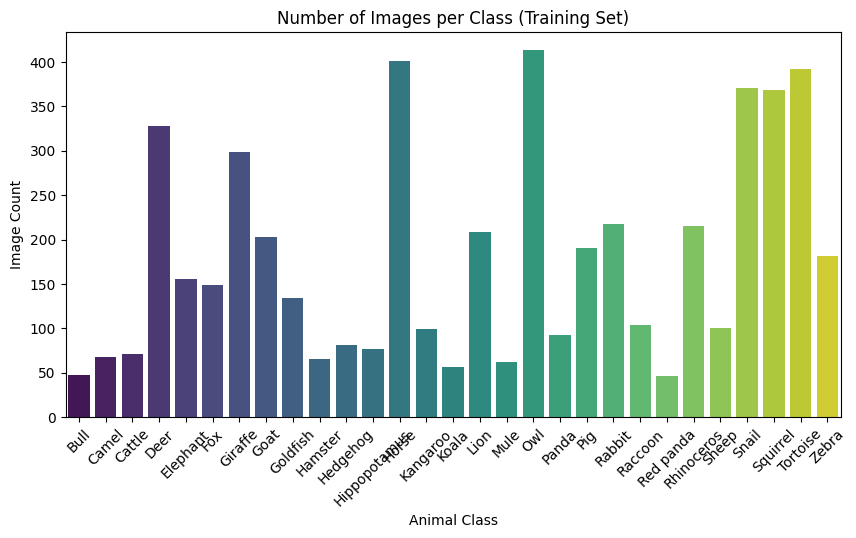

In [7]:
# Plot the number of images per class
plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
plt.title("Number of Images per Class (Training Set)")
plt.ylabel("Image Count")
plt.xlabel("Animal Class")
plt.xticks(rotation=45)
plt.show()

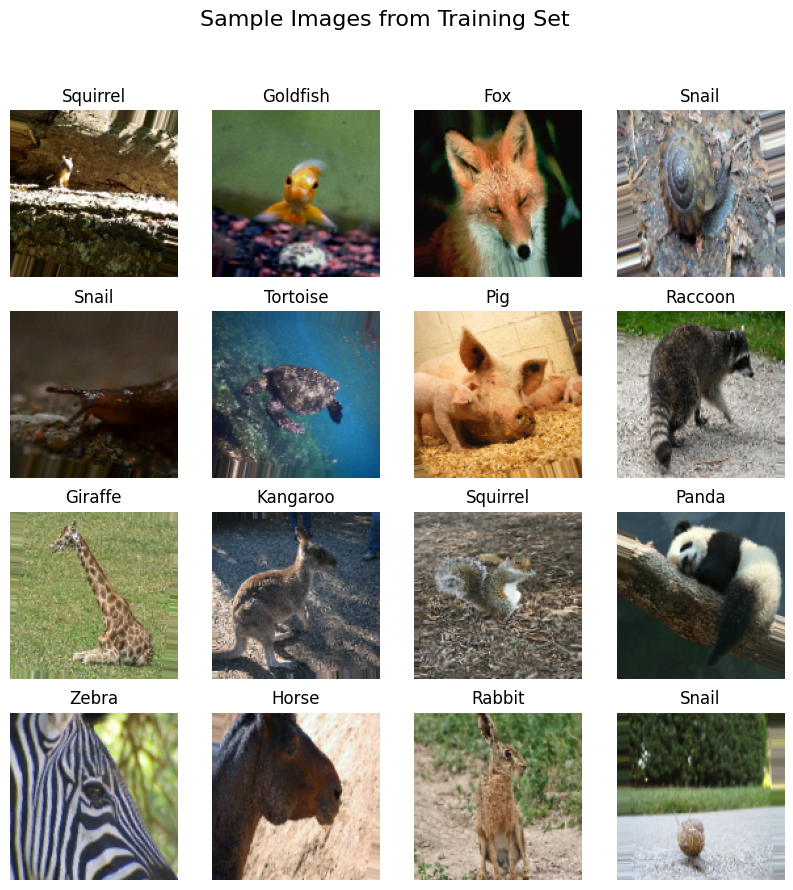

In [8]:
# ================================================
# DISPLAY SOME SAMPLE IMAGES
# ================================================
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10,10))
for i in range(16):  # Display 16 sample images
    plt.subplot(4,4,i+1)
    plt.imshow(x_batch[i])
    class_idx = np.argmax(y_batch[i])
    plt.title(class_names[class_idx])
    plt.axis('off')

plt.suptitle("Sample Images from Training Set", fontsize=16)
plt.show()

In [16]:
# MODEL DEFINITION
def build_cnn(input_shape, classes, use_l2_reg=True, L2_loss_lambda=L2_lambda):
    l2 = regularizers.l2(L2_loss_lambda) if use_l2_reg else None
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2, input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.15),

        Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.2),

        Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.3),

        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2),
        Dropout(0.4),
        Dense(classes, activation='softmax')
    ])
    return model

In [17]:
model = build_cnn((img_height, img_width, 3), num_classes)

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,886,749 (64.42 MB)

 Trainable params: 16,886,301 (64.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size,
    epochs = epochs,
    batch_size = batch_size,
    verbose = 1
)

129/129 ━━━━━━━━━━━━━━━━━━━━ 4080s 32s/step - accuracy: 0.0745 - loss: 4.6916 - val_accuracy: 0.0371 - val_loss: 10.9405


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# EVALUATE MODEL ON TEST DATA
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 1441s 24s/step - accuracy: 0.0245 - loss: 8.8628

✅ Test Accuracy: 0.0635
✅ Test Loss: 10.3839


In [21]:
# GET PREDICTIONS

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 345ms/step


In [22]:
# CLASSIFICATION REPORT

print("\n📊 Classification Report:")
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)


📊 Classification Report:
              precision    recall  f1-score   support

        Bull     0.0000    0.0000    0.0000        73
       Camel     0.0000    0.0000    0.0000        27
      Cattle     0.0000    0.0000    0.0000       171
        Deer     0.0000    0.0000    0.0000       177
    Elephant     0.0000    0.0000    0.0000        33
         Fox     0.0000    0.0000    0.0000        69
     Giraffe     0.0000    0.0000    0.0000        23
        Goat     0.0000    0.0000    0.0000        94
    Goldfish     0.0000    0.0000    0.0000        31
     Hamster     0.0000    0.0000    0.0000        81
    Hedgehog     0.0000    0.0000    0.0000        49
Hippopotamus     0.0000    0.0000    0.0000        22
       Horse     0.0000    0.0000    0.0000       143
    Kangaroo     0.0000    0.0000    0.0000        43
       Koala     0.0000    0.0000    0.0000        24
        Lion     0.0000    0.0000    0.0000       100
        Mule     0.0000    0.0000    0.0000        36
 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


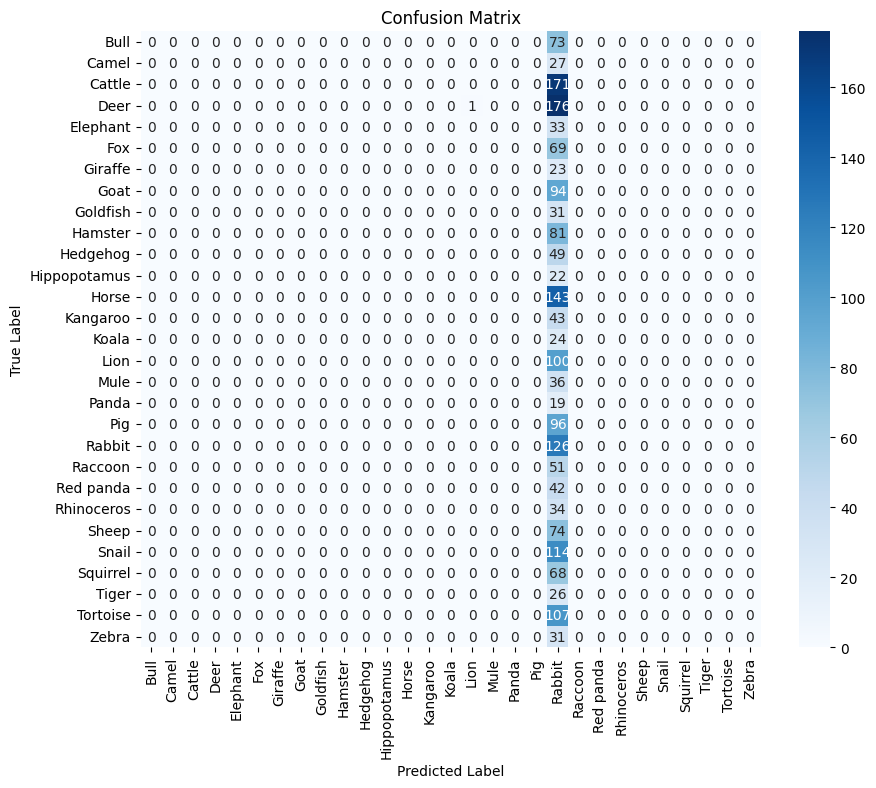

In [23]:
# CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

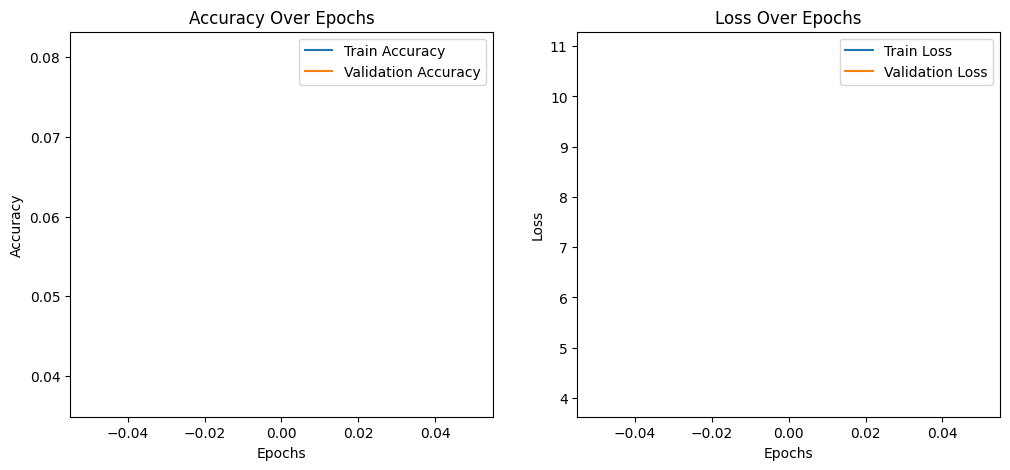

In [24]:
# PLOT TRAINING HISTORY (ACCURACY & LOSS)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [25]:
# F1, PRECISION, RECALL IN SUMMARY

from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"\n🔍 Weighted Precision: {precision:.4f}")
print(f"🔍 Weighted Recall: {recall:.4f}")
print(f"🔍 Weighted F1-score: {f1:.4f}")


🔍 Weighted Precision: 0.0040
🔍 Weighted Recall: 0.0635
🔍 Weighted F1-score: 0.0076


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
